# MNIST digit classification

## Outline of method used

First, we wish to reduce the dimensionality of each sample. Then, we shall have to classify the compressed representation into one of ten categories.

### Using PCA to reduce dimensionality

The aim is to identify useful _features_ from this data sample. To accomplish that, we would like to know which set of pixels are highly correlated, and can hence be considered redundant information. Here's the procedure we follow:

1. Convert each image (square matrix) into a vector.
2. Subtract out the _mean image_ from all those vectors. 
3. Compute the eigenvectors of the correlation/covariance matrix of the training set.  
    - To compute the most important eigen-features, instead of diagonalizing the $d \times d$ dimensional covariance matrix ($where d = 784$), we can instead use a part of the training sample ($k$ samples) to estimate the $k$ most important eigenvectors. Let $A_{k \times d}$ represent the set of training samples chosen. It can be shown that if $v$ is a right eigenvector of $A A^{T}$ with eigenvalue $\lambda$ then $A^{T} v$ is an eigenvector of the full covariance matrix, with eigenvalue $\lambda$ (ref. class notes). Using that trick, we proceed to estimate the few most important eigen-features of the MNIST dataset.
4. Compress each sample by reducing it to the most important _eigen-features_ of the training set. 


### Classifying the compressed vectors

A naive approach to classification could use k-nearest-neighbours (kNN) classifier based on the Euclidean distance, which we first demonstrate. We analyze for any dependence on the number of nearest neighbors used to classify, or the number of training points used to "fit" the classifier. 



## Observations/Results

### On scanning over number of eigenfeatures

While we do this, we use a kNN classifier with 3 neighbors and $10,000$ training points to study whether results improve.

1. A naive calculation of the eigen-features using the covariance matrix would need to diagonalize a $784 \times 784$ sized matrix. So, our approach of using a truncated sample to estimate the eigen-features is only useful if we can get away with using (significantly) fewer than $784$ samples. As the plot above shows, we can get pretty good results with anything like 60-100 samples or more.

2. Improvements slow down after $15-20$ features. We have only $60,000$ training points, so it doesn't make sense to use kNN in a space with much more than $\log_{2}{60,000} \approx 16$ dimensions. For dimensions much higher than that, all points in the training set will be roughly equidistant from the point we wish to classify. (So kNN using multiple neighbours might not be useful?). 
    - In practice, we do see a small improvement (roughly $0.5\%$ reduction in error) as we use 30 features instead of 20.
    - Using 50 features (and $10,000$ training points for kNN classifier) gives an error of $~3.27\%$

### On scanning over the kNN classifier parameters

When doing this, we compress images to the top fifty eigenfeatures.

1. There's practically no dependence on the numberof nearest neighbors used in the kNN classifier (other than a slight hiccup for 2 neighbors).

2. There's a sharp improvement till the number of training samples reaches approximately $2,000$ after which there's a gentle improvement as we improve the number of training samples all the way to $60,000$


---------



In [1]:
import sys
sys.version

'3.6.0 (default, Jan 16 2017, 12:12:55) \n[GCC 6.3.1 20170109]'

In [2]:
import numpy as np
#import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knc

In [3]:
#%matplotlib inline
#np.set_printoptions(precision=4, linewidth=100)

In [4]:
np.random.seed(2017)    # for reproducibility

In [5]:
from keras.datasets import mnist    # just for MNIST data

Using Theano backend.


In [6]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

In [7]:
def showDigit(digitSq, digitLabel=None):
    """Function to plot a single digit, given its image"""
    plt.imshow(digitSq,plt.get_cmap('gray'))
    plt.title(digitLabel)
    plt.xticks([])
    plt.yticks([])

In [8]:
def showDigitList(imList,labelList,figGrid):
    """Function to plot a list of digit images"""
    plt.subplots(figGrid[0],figGrid[1],figsize=(figGrid[1],figGrid[0])) # intelligent way to figsize for generic number of images?
    for i in range(0,len(imList)):
        plt.subplot(figGrid[0],figGrid[1],i+1)
        showDigit(imList[i], labelList[i])
        #         plt.imshow(imList[i], plt.get_cmap('gray'))
        #         plt.title(labelList[i])
        #         plt.xticks([])
        #         plt.yticks([])

## Eyeballing a few images: random examples of each class

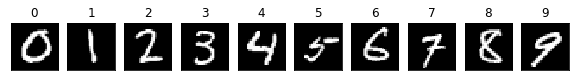

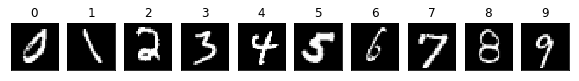

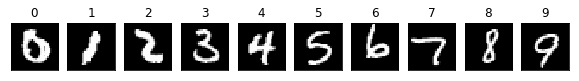

In [9]:
def block1():
    for i in range(3):
        batch=np.array([np.random.choice(np.where(yTrain == i)[0],1) for i in np.arange(10)]).transpose()[0]
        imList = xTrain[batch]
        labelList = yTrain[batch]
        showDigitList(imList,labelList=labelList,figGrid=(1,10))

block1()
plt.show()

## Computing and visualizing the "average" image

In [10]:
mean = np.mean(xTrain,axis=0)

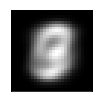

In [11]:
plt.figure(figsize=(1.5,1.5))
showDigit(mean, "")
plt.show()

## Compressing the image into eigenfeatures

In [12]:
dict_labelList = dict()
dict_eValTrnc = dict()
dict_eVectTrnc = dict()
dict_tstErrTrnc = dict()
# How about making all of these elements of a dict which takes their name as the argument :-?

The eigenectors of the covariance matrix will indicate which degrees of freedom are linearly correlated (with the eigenvalue indicating a measure of the correlation). So truncating to the top few eigenvectors is analogous to a simplistic attempt at reducing to the best "features" of the data.

**For each of the exported properties (labelList, eval_trnc, eVect_trnc, tstErr_trnc), insert into a corresponding dictionary which uses numbers from reduceFactor_list as the keys. That way we can easily insert and access as needed.**


In [13]:
def sampleTrainingData(X,Y,reduceFactor):
    """Randomly sample the training data by reducing its size by a factor of `reduceFactor`"""
    sampleSize = np.int(X.shape[0]/reduceFactor)
    batch=np.random.choice(X.shape[0], sampleSize)
    imList = X[batch]
    labelList = Y[batch]
    return (imList, labelList)

In [14]:
# def sampleHistPlot(labelList):
#     plt.hist(labelList,bins=np.arange(-1,10)+0.5)
#     plt.xlim(xmin=-0.5,xmax=9.5)

In [15]:
def spectrum(matrix):
    """Generates spectrum with eigenvalues ordered by descending; 
    assuming all egvals positive (which applies to covariances)"""
    eVal, eVectTranspose = np.linalg.eigh(matrix)
    descOrder = eVal.argsort()[::-1]
    eVal = eVal[descOrder]
    eVect = eVectTranspose.transpose()[descOrder]
    return (eVal, eVect)

In [16]:
def egvalPlot(eVal_list):
    """Plots descending spectrum of eigenvalues"""
    plt.plot(eVal_list)
    plt.yscale('log')
    #plt.ylim(ymin=1e2)
    plt.grid()

In [17]:
def plotFeats(eFt):
    """Visualize important eigen-features"""
    fig, ax = plt.subplots(4,5, figsize=(8,6))

    for i in np.arange(0,20):
        loc = ax.reshape((-1))[i]
        loc.imshow(eFeat[i].reshape((28,28)), plt.get_cmap('gray'))
        loc.set_axis_off()

    plt.show()

In [18]:
def findFeats(imList):
    """Find important features given a truncated sample of images,
    assuming that the incoming images are already mean-shifted"""
    imVecList = np.reshape(imList, (-1,784)) # convert square images to linear vectors
    mat = np.dot(imVecList,imVecList.transpose())
    eVal_trnc, eVect_trnc_almost = spectrum(mat)
    eVect_trnc = np.dot(eVect_trnc_almost,imVecList) # right multiplying because numpy returns eigenvectors as columns instead of rows
    return(eVal_trnc, eVect_trnc)

In [19]:
def encodeToFeats(imList, mean, eFt):
    return np.dot(np.reshape(imList - mean,(-1,784)),eFt.transpose())

In [20]:
def decodeFromFeats(featList, mean, eFt):
    return (np.reshape(np.dot(featList,eFt),(-1,28,28))+mean)

## Classifying using kNN

In [21]:
# Feed only 'k' of the eVects as eFt
# Model = Mean subtraction followed by projection followed by kNN classification

def evaluateModel_kNN(classifier, xTrain, yTrain, xTest, yTest, mean, eFt, nTestBatch):
    # Create a classifier that uses right numFeats
    classifier.fit(encodeToFeats(xTrain, mean, eFt),yTrain) # Considering all 60,000 points is an overload?
    
    #batch=np.random.choice(xTest.shape[0],nBatch)
    batch=np.arange(0, nTestBatch)
        
    # Very important to subtract the mean from xTest !!!
    xTest_feats = encodeToFeats(xTest, mean, eFt)
    testScore = classifier.score(xTest_feats[batch], yTest[batch])

    return 1.0-testScore

## Scanning over number of eigenfeatures

In [22]:
def scanNumFeats(classifier, xTrain, yTrain, reduceFactor, numFeatsList, evaluateModel):
    (imList, labelList) = sampleTrainingData(xTrain, yTrain, reduceFactor)
    mean = np.mean(imList,axis=0)
    #sampleHistPlot(labelList)
    (eVal_trnc, eVect_trnc) = findFeats(imList - mean)
    #egvalPlot(eVal_trnc)
    #plotFeats(eVect_trnc)
    
    def scoreModel(numFeats):
        return evaluateModel_kNN(classifier, xTrain, yTrain, xTest, yTest, mean, eVect_trnc[0:numFeats], 10000)

    tstErr_trnc = np.vectorize(scoreModel)(numFeatsList)
    return (labelList, eVal_trnc, eVect_trnc, tstErr_trnc)

In [23]:
def runPipeline(classifier, rfList, numFeatsList, evaluateModel):
    for reduceFactor in rfList:
        (labelList, eVal_trnc, eVect_trnc, tstErr_trnc) = scanNumFeats(classifier, xTrain, yTrain, reduceFactor, numFeatsList, evaluateModel)
        dict_labelList[reduceFactor] = labelList
        dict_eValTrnc[reduceFactor] = eVal_trnc
        dict_eVectTrnc[reduceFactor] = eVect_trnc
        dict_tstErrTrnc[reduceFactor] = tstErr_trnc        

In [25]:
%%time
classifier = knc(n_neighbors=3,p=2)
#reduceFactor_list = np.array([100,300,1000,3000])
reduceFactor_list = np.array([100])
numFeatsList = np.concatenate([np.arange(1,11), np.arange(11,21,2),np.arange(21,41,4),np.arange(41,61,6)])
runPipeline(classifier,reduceFactor_list, numFeatsList, evaluateModel_kNN)

CPU times: user 6min 56s, sys: 33.7 s, total: 7min 30s
Wall time: 6min 36s


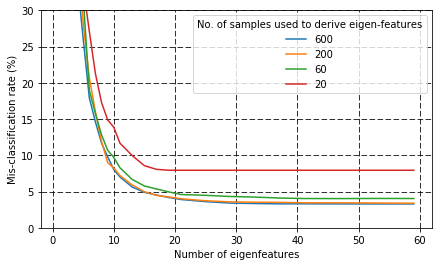

In [64]:
#plt.plot(kVals,trnErr, label='Training error')
plt.figure(figsize=(7,4))

#plt.subplot(1,2,1)
for rf in dict_tstErrTrnc.keys():
    plt.plot(numFeatsList, 100*dict_tstErrTrnc[rf], label=int(xTrain.shape[0]/rf))
plt.grid()
plt.grid(b=True, which='major', color='k', linestyle='--')
plt.grid(b=True, which='minor', color='k', linestyle='dotted')
plt.ylim(ymin=0,ymax=30)
plt.ylabel("Mis-classification rate (%)")
plt.xlabel("Number of eigenfeatures")

# plt.subplot(1,2,2)
# for rf in reduceFactor_list:
#     plt.plot(numFeatsList, dict_tstErrTrnc[rf], label=int(xTrain.shape[0]/rf))
# plt.grid()
# plt.grid(b=True, which='major', color='k', linestyle='--')
# plt.grid(b=True, which='minor', color='k', linestyle='dotted')
# plt.ylim(ymin=1e-2,ymax=2e-1)
# plt.yscale('log')

#plt.title("Error rate when changing the number of eigenfeatures")
plt.legend(loc='upper right',title="No. of samples used to derive eigen-features")

plt.show()

## Scanning over kNN parameters

In [29]:
def block7(NumNeigh, NumPts, TestBatch):
    eFt = dict_eVectTrnc[100][0:50]

    classifier = knc(n_neighbors=NumNeigh,p=2)
    classifier.fit(encodeToFeats(xTrain[0:NumPts], mean, eFt),yTrain[0:NumPts])
    sco = classifier.score(encodeToFeats(xTest[0:TestBatch],mean,eFt),yTest[0:TestBatch])
    return 1.0 - sco

In [30]:
perf_vs_NumNeigh = np.array([block7(NumNeigh, 10000, 10000) for NumNeigh in np.arange(1,10)])

In [31]:
NumPts_list = np.concatenate([np.arange(100,3000,100),np.arange(3000,10000,500),np.arange(10000,60000,2000)])
perf_vs_NumPts = np.array([block7(3, NumPts, 10000) for NumPts in NumPts_list])

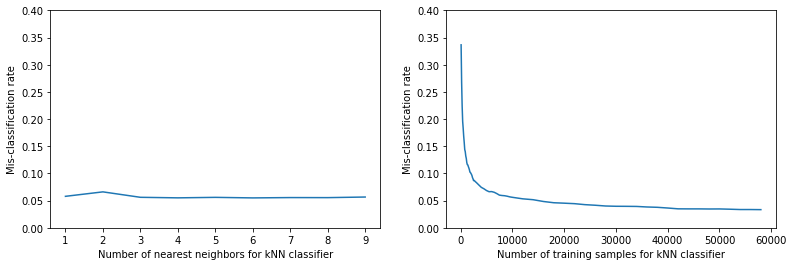

In [39]:
plt.subplots(1,2,figsize=(13,4))

plt.subplot(1,2,1)
plt.plot(np.arange(1,10),perf_vs_NumNeigh)
plt.xlabel("Number of nearest neighbors for kNN classifier")
plt.ylabel("Mis-classification rate")
plt.ylim(ymin=0.0,ymax=0.4)


plt.subplot(1,2,2)
plt.plot(NumPts_list,perf_vs_NumPts)
plt.xlabel("Number of training samples for kNN classifier")
plt.ylabel("Mis-classification rate")
plt.ylim(ymin=0.0,ymax=0.4)


plt.show()

In [41]:
evaluateModel_kNN(classifier, xTrain, yTrain, xTest, yTest, mean, dict_eVectTrnc[100][0:50], 10000)

0.032699999999999951

## Addendum

### Looking at pictures of eigendigits

Presented below are the top 20 eigenfeatures.

### Looking at images to see where our model succeeds and fails


In [31]:
def block4():
    classifier = knc(n_neighbors=3,p=2)
    
    imList = xTrain[0:600]
    (eVal_trnc, eVect_trnc) = findFeats(imList - np.mean(imList))

    eFt = eVect_trnc[0:50]
    classifier.fit(encodeToFeats(xTrain, mean, eFt),yTrain) # Considering all 60,000 points is an overload?
    return classifier.predict(encodeToFeats(xTest,mean,eFt))

zTest = block4()

In [27]:
flawedGuessBatch = np.where(zTest != yTest)
correctGuessBatch = np.where(zTest == yTest)

### Pictures of eigendigits

Presented below are the top 20 eigenfeatures.


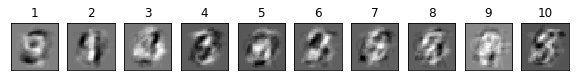

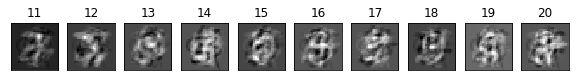

In [54]:
def block2():
    imList = decodeFromFeats(np.eye(20), mean, dict_eVectTrnc[1000][0:20])
    rowSize = 10
    for i in np.arange(0,20,rowSize):
        showDigitList(imList[i:i+rowSize],labelList=np.arange(1+i,1+i+rowSize),figGrid=(1,rowSize))

block2()
plt.show()

### Spectrum of eigenfeatures

By staring at the eigenvalues of the full covariance matrix (it is cheap to compute for $784 \times 784$) we see that we see that 20-70 eigenfeatures should be more than sufficient.


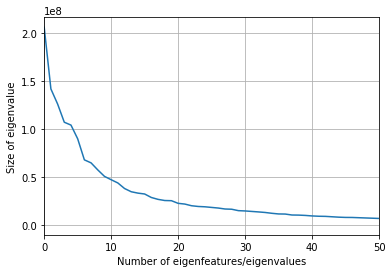

In [58]:
plt.figure()
egvalPlot(dict_eValTrnc[100])
plt.yscale('linear')
plt.xlim(xmin=0,xmax=50)
plt.ylabel("Size of eigenvalue")
plt.xlabel("Number of eigenfeatures/eigenvalues")
plt.show()

### Where does our model work?

Below, we plot images on which our model classified _correctly_, along with their correct labels, and the compressed versions along with estimated class labels. We note that the model succeeds when there is a leftover (white colored) signal even after the model has been compressed.

#### Succeeds

Below, we plot images on which our model classified _correctly_, along with their correct labels, and the compressed versions along with estimated class labels. We note that the model succeeds when there is a leftover (white colored) signal even after the model has been compressed.

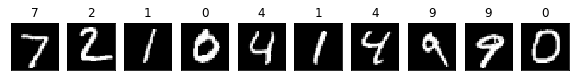

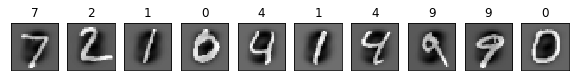

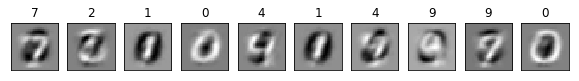

In [46]:
def block6():
    #batch = np.random.choice(flawedGuessBatch[0],5)
    batch = correctGuessBatch[0][0:10]
    imList = xTest[batch]
    labelList_actual = yTest[batch]
    showDigitList(imList, labelList_actual,figGrid=(1,batch.shape[0]))
    
    showDigitList(imList - mean, labelList_actual,figGrid=(1,batch.shape[0]))

    labelList_estimated = zTest[batch]
    #labelList = np.vstack((labelList_actual,labelList_estimated)).transpose()
    eFt = dict_eVectTrnc[100][0:16]
    imList = decodeFromFeats(encodeToFeats(imList,mean,eFt),mean,eFt)
    showDigitList(imList, labelList_estimated,figGrid=(1,batch.shape[0]))

#plt.figure()
block6()
plt.show()

#### Fails

We can plot histograms for the fraction error in classifying each digit, and also the histogram for probability of the image corresponding to each digit, among the incorrect examples. Since all digits have roughly the same population, the two graphs are very similar.

Based on the histograms, we note that the model seems to have a better success rate (than average) on $\{0,1,6\}$ and a worse success rate (than average) on $\{3,4,8,9\}$. One could investigate the statistical significance of that conclusion, but I have not explored that here.

Below, we plot images on which the model classified _incorrectly_, along with their correct labels, and the compressed versions along with estimated class labels. 

Note that "mean subtraction" followed by compression seems to have obliterated important pixel information. This seems to be a common failure mode, and sufficiently explains all the mis-classified examples we have below. Based on this, we can conclude that the PCA has not picked up features that humans naturally identify, even in the "mean subtracted" samples. To improve on this performance, we thus need a more powerful model involving higher-order features rather than simply linear combinations of pixels.


In [32]:
h0 = np.histogram(yTest)[0]
#print("Samples of each digit: ", h0)
h1 = np.histogram(yTest[correctGuessBatch])[0]
h2 = np.histogram(yTest[flawedGuessBatch])[0]
fracError = h2/h0
#np.std(fracError)
#stDev = np.sqrt((h2*(1-fracError)**2 + h1*(fracError)**2)/h0)

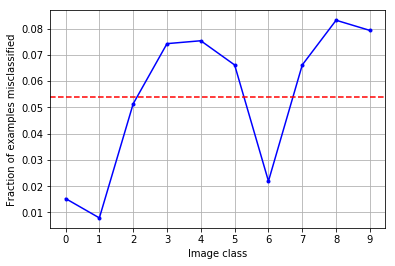

In [39]:
#plt.subplots(1,2, figsize=(10,3))
#plt.subplot(1,2,1)
plt.ylabel("Fraction of examples misclassified")
plt.xlabel("Image class")
plt.plot(range(10),fracError,'b.-')
#plt.errorbar(range(10),fracError,yerr=stDev)
plt.axhline(y=np.mean(fracError), color='r', linestyle='--')
plt.xticks(np.arange(0,10))
plt.grid('on')
plt.show()

# plt.subplot(1,2,2)
# plt.title("Probability of digit, given misclassification")
# plt.plot(range(10),h2/np.sum(h2),'g.-')
# #plt.errorbar(range(10),h2/np.sum(h2),yerr=2*np.std(fracError))
# plt.axhline(y=0.1, color='r', linestyle='--')
# plt.show()

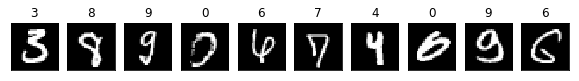

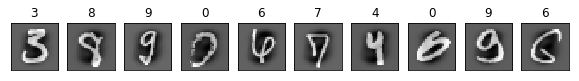

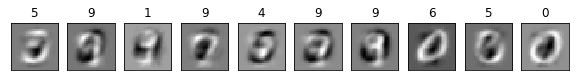

In [49]:
def block5():
    batch = np.random.choice(flawedGuessBatch[0],10)
    #batch = flawedGuessBatch[0][0:10]
    imList = xTest[batch]
    labelList_actual = yTest[batch]
    showDigitList(imList, labelList_actual,figGrid=(1,batch.shape[0]))
    
    showDigitList(imList - mean, labelList_actual,figGrid=(1,batch.shape[0]))


    labelList_estimated = zTest[batch]
    #labelList = np.vstack((labelList_actual,labelList_estimated)).transpose()
    eFt = dict_eVectTrnc[100][0:16]
    imList = decodeFromFeats(encodeToFeats(imList,mean,eFt),mean,eFt)
    showDigitList(imList, labelList_estimated,figGrid=(1,batch.shape[0]))

#plt.figure()
block5()
plt.show()

## Addendum: Using kMeans for clustering

### Using kMeans for clustering and then classification

Note, that the classification time for each test sample grows linearly with the number of training samples fed into kNN classifier. Therefore, we would like to try a classification scheme that compresses the compressed repersentation further. A simple example of that is the k-means algorithm for clustering. But we observe that kMeans performs poorly (about $89\%$ misclassification rate, barely better than random labeling!), even though kNN is quite successful. Based on the poor performance of kMeans to classify our test samples, we conclude that the decision boundaries in the compressed space are not linear. Therefore, one would need to transform the projections nonlinearly before attempting a simpler classifier.


In [50]:
from sklearn.cluster import KMeans

In [51]:
estimator = KMeans(n_clusters=10)
estimator.fit(encodeToFeats(xTrain,mean,dict_eVectTrnc[100][0:30]), y=yTrain)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
def evaluateModel_kMeans(estimator, xTrain, xTest, mean, eFt, nTestBatch):
    xTr_feats = encodeToFeats(xTrain, mean, eFt)
    xTest_feats = encodeToFeats(xTest, mean, eFt)

    batch=np.arange(0, nTestBatch)
        
    # Very important to subtract the mean from xTest !!!
    xTest_feats = encodeToFeats(xTest, mean, eFt)
    #testScore = estimator.score(xTest_feats[batch], yTest[batch])
    #testScore = np.sum(estimator.predict(encodeToFeats(xTest[0:nTestBatch], mean, eFt)) == yTest[0:nTestBatch])/nTestBatch
    testScore = np.sum(np.random.randint(0,10,nTestBatch) == yTest[0:nTestBatch])/nTestBatch
    return (1.0-testScore)

In [53]:
evaluateModel_kMeans(estimator, xTrain,xTest,mean,dict_eVectTrnc[100][0:30],1000)

0.89300000000000002

**kMeans performs poorly (about the same as random labeling), even though kNN is quite successful.**
This means that, even though points are close-by in the truncated feature space, the decision boundaries are highly non-linear.